In this notebook, I experiment how KV caching can reduce time in genertaing token. KV caching is a technique to optimize token generation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Loading GPT 2 from HuggingFace
GPT2 is a lightweight and small model. It is fast model as well.

In [5]:
model_name = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Save the model locally
model.save_pretrained('./models/gpt2')
tokenizer.save_pretrained('./models/gpt2')

('./models/gpt2/tokenizer_config.json',
 './models/gpt2/special_tokens_map.json',
 './models/gpt2/vocab.json',
 './models/gpt2/merges.txt',
 './models/gpt2/added_tokens.json',
 './models/gpt2/tokenizer.json')

# How next token is generated in auto-regressive models

In [6]:
prompt = "The quick brown fox jumps over the"
inputs = tokenizer(prompt, return_tensors='pt')
inputs


{'input_ids': tensor([[  464,  2068,  7586, 21831, 18045,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

As we can see, the input is converted into a tensor having 7 values, one each for the word in prompt.

In [12]:
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
outputs.logits.shape


torch.Size([1, 7, 50257])

The output is a tensor indicates we have 1 batch with 7 tokens and 50527 possible tokens from the vocabulary.

In [15]:
last_logits = logits[:, -1, :]
next_token_id = last_logits.argmax(dim=-1)
next_token_id

tensor([13990])

In [16]:
tokenizer.decode(next_token_id)

' fence'

We'll print and see the top 10 probable words for the last word from the prompt

In [20]:
top_k = last_logits.topk(10)
tokens = [tokenizer.decode(token) for token in top_k.indices[0]]
tokens

[' fence',
 ' edge',
 ' wall',
 ' table',
 ' top',
 ' ground',
 ' bar',
 ' railing',
 ' tree',
 ' fox']

# Code to generate the next word regressively

In [21]:
next_inputs = {
    'input_ids': torch.cat([inputs['input_ids'],next_token_id.reshape(1,1)],dim=1),
    'attention_mask': torch.cat([inputs['attention_mask'],torch.tensor([[1]])],dim=1)
}
with torch.no_grad():
    outputs = model(**next_inputs)
next_logits = outputs.logits[:, -1, :]
next_token_id = next_logits.argmax(dim=-1)
next_token_id


tensor([290])

In [23]:
print(next_inputs['input_ids'].shape)
print(next_inputs['attention_mask'].shape)

torch.Size([1, 8])
torch.Size([1, 8])


## Text generation helper function

In [24]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[:,-1,:]
    next_token_id = last_logits.argmax()
    return next_token_id

Lets generate 10 tokens in a row and see how much time it takes.

In [28]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(10):
    start_time = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - start_time]

    next_inputs = {
        'input_ids' : torch.cat([next_inputs['input_ids'], next_token_id.reshape((1,1))], dim=1),
        'attention_mask': torch.cat([next_inputs['attention_mask'], torch.tensor([[1]])], dim=1)
    }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"Time taken to generate(duration_in_seconds): {sum(durations_s)}")

Time taken to generate(duration_in_seconds): 0.27249741554260254


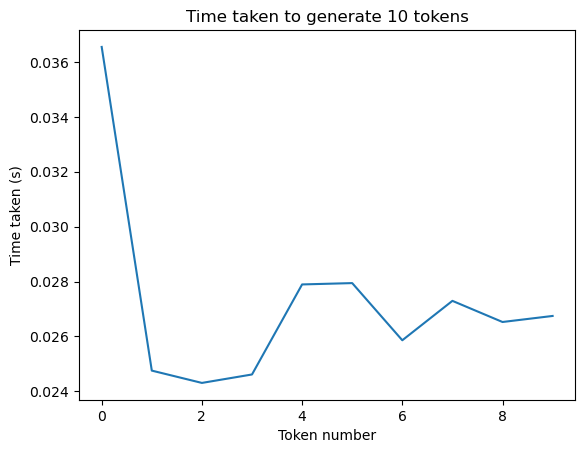

In [31]:
plt.plot(durations_s)
plt.xlabel('Token number')
plt.ylabel('Time taken (s)')
plt.title('Time taken to generate 10 tokens')
plt.show()


## KV caching and how it speeds up token geenration

This is a technique to improve latency by storing tensors in the attention head for use in subsequent generation steps

In [47]:
def generate_token_with_kv_caching(inputs):
    #print(inputs['input_ids'].shape)
    #print(inputs['attention_mask'].shape)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[:,-1,:]
    next_token = last_logits.argmax()
    return next_token, outputs.past_key_values

In [48]:
generated_tokens = []
next_inputs = inputs
duration_kc = []
for _ in range(10):
    start_time = time.time()
    next_token_id, past_key_values = \
        generate_token_with_kv_caching(next_inputs)
    duration_kc += [time.time() - start_time]

    next_inputs = {
        'input_ids' : next_token_id.reshape((1, 1)),
         "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        'past_key_values': past_key_values
    }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

In [50]:
print(f"{sum(duration_kc)} s")
print(generated_tokens)

0.18887782096862793 s
[' fence', ' and', ' runs', ' into', ' the', ' bushes', '.', '\n', '\n', '"']


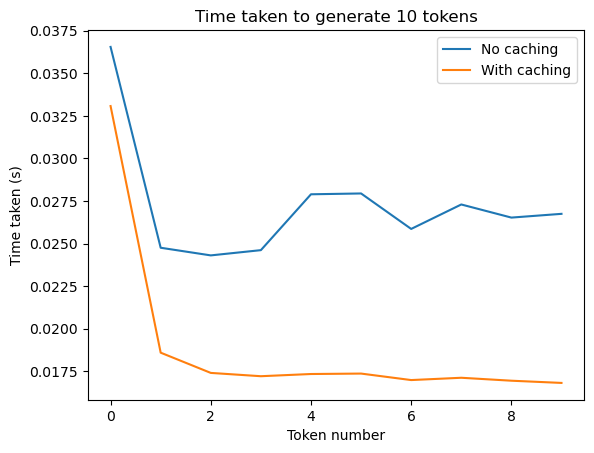

In [52]:
plt.plot(durations_s)
plt.plot(duration_kc)
plt.xlabel('Token number')
plt.ylabel('Time taken (s)')
plt.title('Time taken to generate 10 tokens')
plt.legend(['No caching', 'With caching'])
plt.show()